# Week 7: BentoML for Production Homework

The goal of this homework is to familiarize you with BentoML and how to build and test an ML production service.

## Email from your manager

Good morning recruit! It's good to have you here! I have an assignment for you. I have a data scientist that's built
a credit risk model in a jupyter notebook. I need you to run the notebook and save the model with BentoML and see
how big the model is. If it's greater than a certain size, I'm going to have to request additional resources from 
our infra team. Please let me know how big it is.

Thanks,

Mr McManager


## Question 1

* Install BentoML
* What's the version of BentoML you installed?
* Use `--version` to find out

Use the following commands

```bash
# install
$ pip install bentoml
...
# check version
$ bentoml --version
bentoml, version 1.0.7
```

**Answer:** 1.0.7


## Question 2

Run the notebook which contains the xgboost model from module 6 i.e previous module and save the xgboost model with BentoML. To make it easier for you we have prepared this [notebook](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/07-bentoml-production/code/train.ipynb). 


How big approximately is the saved BentoML model? Size can slightly vary depending on your local development environment.
Choose the size closest to your model.

* 924kb
* 724kb
* 114kb
* 8kb


After running the notebook provided to train and save the model, use the command:

```bash
$ bentoml models list
Tag                                 Module           Size        Creation Time       
credit_risk_model:frtuzpcxcox6ndkh  bentoml.xgboost  116.30 KiB  2022-10-28 17:52:17 
```

**Answer:** actual model size 116.30 KiB, most near with the options given 114 Kb

## Another email from your manager

Great job recruit! Looks like I won't be having to go back to the procurement team. Thanks for the information.

However, I just got word from one of the teams that's using one of our ML services and they're saying our service is "broken"
and their trying to blame our model. I looked at the data their sending and it's completely bogus. I don't want them
to send bad data to us and blame us for our models. Could you write a pydantic schema for the data that they should be sending?
That way next time it will tell them it's their data that's bad and not our model.

Thanks,

Mr McManager

## Question 3

Say you have the following data that you're sending to your service:

```json
{
  "name": "Tim",
  "age": 37,
  "country": "US",
  "rating": 3.14
}
```

What would the pydantic class look like? You can name the class `UserProfile`.

Using a pydantic model and builtin data types:

```python
from pydantic import BaseModel


class UserProfile(BaseModel):
    name: str
    age: int
    country: str
    rating: float
```

## Email from your CEO

Good morning! I hear you're the one to go to if I need something done well! We've got a new model that a big client
needs deployed ASAP. I need you to build a service with it and test it against the old model and make sure that it performs
better, otherwise we're going to lose this client. All our hopes are with you!

Thanks,

CEO of Acme Corp

## Question 4

We've prepared a model for you that you can import using:

```bash
curl -O https://s3.us-west-2.amazonaws.com/bentoml.com/mlzoomcamp/coolmodel.bentomodel
bentoml models import coolmodel.bentomodel
```

What version of scikit-learn was this model trained with?

* 1.1.1
* 1.1.2
* 1.1.3
* 1.1.4
* 1.1.5

After downloading and importing the model with the commands provided, run 

```bash
# find out the model tag
$ bentoml models list
 Tag                                   Module           Size        Creation Time       
 credit_risk_model:frtuzpcxcox6ndkh    bentoml.xgboost  116.30 KiB  2022-10-28 17:52:17 
 mlzoomcamp_homework:qtzdz3slg6mwwdu5  bentoml.sklearn  5.79 KiB    2022-10-13 15:42:14 
# get the model details
$ bentoml models get mlzoomcap_homework:latest
```
```yaml
name: mlzoomcamp_homework                                                                                                                                                                   
version: qtzdz3slg6mwwdu5                                                                                                                                                                    
module: bentoml.sklearn                                                                                                                                                                      
labels: {}                                                                                                                                                                                   
options: {}                                                                                                                                                                                  
metadata: {}                                                                                                                                                                                 
context:                                                                                                                                                                                     
  framework_name: sklearn                                                                                                                                                                    
  framework_versions:                                                                                                                                                                        
    scikit-learn: 1.1.1                                                                                                                                                                      
  bentoml_version: 1.0.7                                                                                                                                                                     
  python_version: 3.9.12                                                                                                                                                                     
signatures:                                                                                                                                                                                  
  predict:                                                                                                                                                                                   
    batchable: false                                                                                                                                                                         
api_version: v1                                                                                                                                                                              
creation_time: '2022-10-13T20:42:14.411084+00:00'   
```

**Answer:** 1.1.1

## Question 5 

Create a bento out of this scikit-learn model. The output type for this endpoint should be `NumpyNdarray()`

Send this array to the Bento:

```
[[6.4,3.5,4.5,1.2]]
```

You can use curl or the Swagger UI. What value does it return? 

* 0
* 1
* 2
* 3

(Make sure your environment has Scikit-Learn installed) 


First we write our service code:

```python
import bentoml
from bentoml.io import NumpyNdarray, JSON

model_ref = bentoml.sklearn.get("mlzoomcamp_homework:latest")
model_runner = model_ref.to_runner()

service = bentoml.Service("mlzoomcamp_homework", runners=[model_runner])

@service.api(input=NumpyNdarray(), output=NumpyNdarray())
def predict(vector):
    prediction = model_runner.predict.run(vector)
    return prediction

```

Then we can run it with the command given we called the service code `service.py`
```bash
$ bentoml serve service.service
```

We can make a request to our service with `curl` with the following command:
```bash
$ curl -X 'POST' \
  'http://0.0.0.0:3000/predict' \
  -H 'accept: application/json' \
  -H 'Content-Type: application/json' \
  -d '[[6.4,3.5,4.5,1.2]]'
[1]
```

**Answer:** 1

## Question 6

Ensure to serve your bento with `--production` for this question

Install locust using:

```bash
pip install locust
```

Use the following locust file: [locustfile.py](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/07-bento-production/locustfile.py)

Ensure that it is pointed at your bento's endpoint (In case you didn't name your endpoint "classify")

<img src="https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/course-zoomcamp/cohorts/2022/07-bento-production/resources/classify-endpoint.png">

Configure 100 users with ramp time of 10 users per second. Click "Start Swarming" and ensure that it is working.

Now download a second model with this command:

```bash
curl -O https://s3.us-west-2.amazonaws.com/bentoml.com/mlzoomcamp/coolmodel2.bentomodel
```

Or you can download with this link as well:
[https://s3.us-west-2.amazonaws.com/bentoml.com/mlzoomcamp/coolmodel2.bentomodel](https://s3.us-west-2.amazonaws.com/bentoml.com/mlzoomcamp/coolmodel2.bentomodel)

Now import the model:

```bash
bentoml models import coolmodel2.bentomodel
```

Update your bento's runner tag and test with both models. Which model allows more traffic (more throughput) as you ramp up the traffic?

**Hint 1**: Remember to turn off and turn on your bento service between changing the model tag. Use Ctl-C to close the service in between trials.

**Hint 2**: Increase the number of concurrent users to see which one has higher throughput

Which model has better performance at higher volumes?

* The first model
* The second model


Testing both models at peak concurrency of 20k and spawn rate of 500:

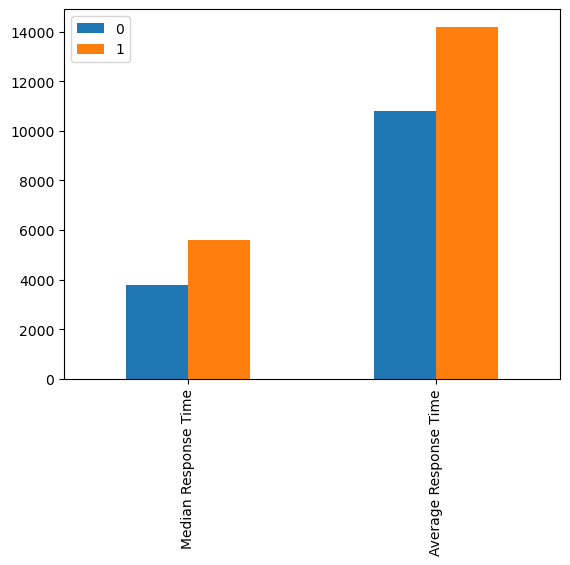

In [14]:
import pandas as pd

results = pd.concat([
    pd.read_csv("model1_loadtest.csv").dropna(),
    pd.read_csv("model2_loadtest.csv").dropna(),
]).reset_index(drop=True)

results[[
    "Median Response Time",
    "Average Response Time"
]].T.plot(kind="bar");

## Email from marketing

Hello ML person! I hope this email finds you well. I've heard there's this cool new ML model called Stable Diffusion.
I hear if you give it a description of a picture it will generate an image. We need a new company logo and I want it
to be fierce but also cool, think you could help out?

Thanks,

Mike Marketer